# Chess games dataset

Цей набір даних містить інформацію про величезну кількість шахових онлайн-ігор, включаючи подробиці про кількість ходів, використане відкриття та результат гри. За допомогою цього датасету ми можемо дослідити взаємозв’язки між різними відкриттями та ймовірністю виграшу, виявити інформацію, яка може допомогти нам покращити нашу гру та отримати конкурентну перевагу.

##### Імпортуємо всі потрібні біліотеки та читаємо датасет

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from scipy import interp
from itertools import cycle


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('chess_games.csv')
df.head()


,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation
1,2,True,16,Resign,Black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation
2,3,True,61,Mate,White,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation
3,4,True,61,Mate,White,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,NaN,Zukertort Variation
4,5,True,95,Mate,White,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,NaN


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

##### Бачимо, що багато змінних, які мають тип об'єктів, тому на них в подальшому потрібно буде звернути більше уваги.



Подивившись на датасет, ми можемо побачити деякі стовпці, від яких виграш одного чи іншого гравця ніяк не залежить і саме тому їх одразу відкинемо. Після того як ми відкинули деяку кількість стовпців вже можна оцінити кількість наявних значень в датасеті.

In [4]:
columns_to_drop = ['white_id', 'black_id', 'moves', 'opening_fullname', 'opening_code']
df.drop(columns=columns_to_drop, inplace=True)




##### Датасет дуже великий і деякі комірки виконуються дуже довго, тому перемішаємо дані за допомогою функції shuffle і обріжемо.

In [5]:
from sklearn.utils import shuffle

# Перемішати DataFrame
shuffled_df = shuffle(df, random_state=42)  # random_state для відтворюваності результату

# Видалити половину даних
half_len = len(shuffled_df) // 2
shuffled_df = shuffled_df.iloc[:half_len]

# Зберегти змінений DataFrame
shuffled_df.to_csv('shuffled_and_half_dataset.csv', index=False)
shuffled_df = shuffled_df.reset_index(drop=True)


In [6]:
df = shuffled_df
df.shape

(10029, 12)





Побудуємо кореляційну матрицю для того, щоб отримати орієнтир на те, з якими стовпцями потрібно буде працювати більше.

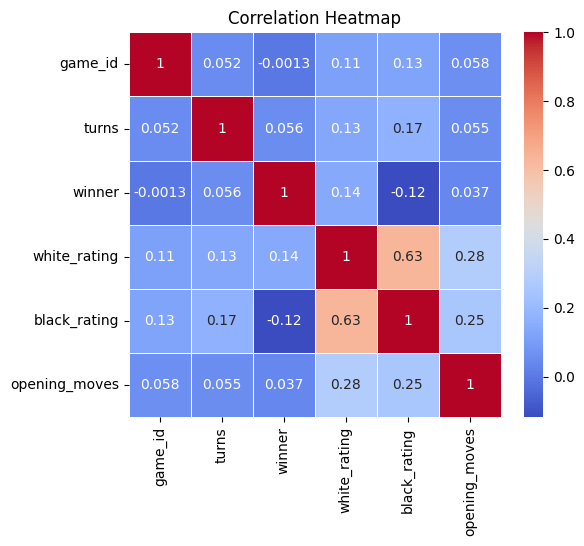

In [7]:
# Замінити "black" на 0 і "white" на 1 у стовпці "winner"
df['winner'] = df['winner'].replace({'Black': 0, 'White': 1, 'Draw': 2})

# Включити "winner" до кореляційної матриці
numeric_columns = df.select_dtypes(include='number')
correlation_matrix = numeric_columns.corr()

# Побудуйте heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

З кореляційної матриці можна побачити, що таргетована зміна мало з цим корелюється, але все ж таки має сенс попрацювати зі стовпцями рейтингу білих та чорних гравців, бо там можемо бачити найбільшу кореляцію.


Далі побудуємо рейтингові залежності і позначимо види завершення ігор, щоб побачити їх розподіл. 

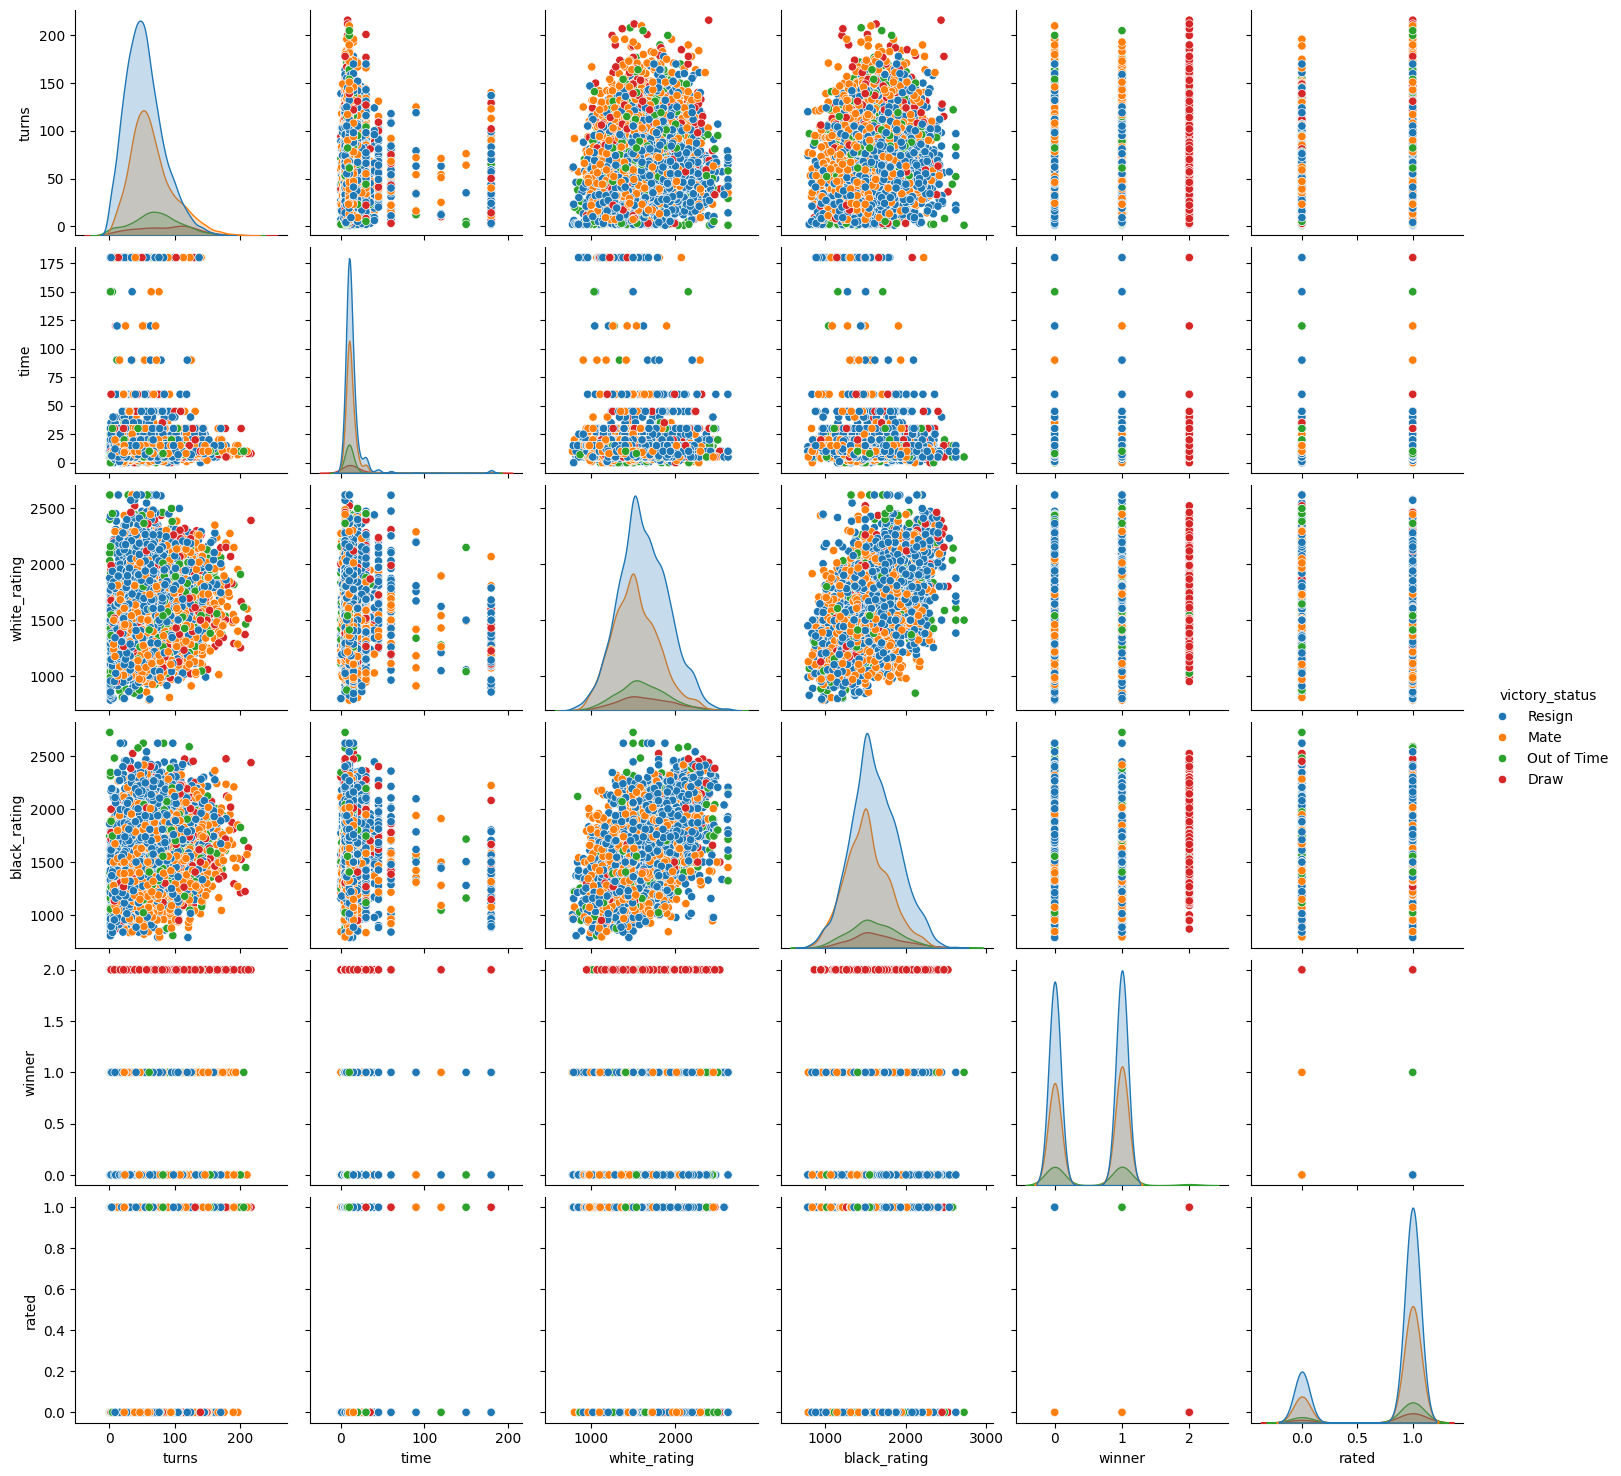

In [8]:

#Розділимо кожен запис на символ «+» і збережу лише перший маркер.
#Перетворити в числовий тип
df['time_increment'] = df['time_increment'].str.split('+').str[0]
df['time'] = pd.to_numeric(df['time_increment'])
df = df.drop('time_increment', axis=1).copy()

# Тепер побудова pairplot
sns.pairplot(data=df, vars=['turns', 'time', 'white_rating', 'black_rating', 'winner', 'rated'], hue='victory_status', diag_kind='kde')



З побудованих графіків модемо побачити, що зміна 'rated' дуже мало впливає, що є цілком логічно. Немає різниці чи рейтингова зіграна, якщо вона все одно один з чотирьох можливих завершень. На цій підставі цю змінну також можна видалити.

In [9]:
df = df.drop(['rated'], axis = 1)

Дослідимо дані на нульові значення, для подальшого видалення чи заповнення.

In [10]:
df.columns[df.isna().any()].tolist()

['opening_response', 'opening_variation']

За допомогою графіку зробимо висновок щодо видалення чи заповнення стовпців з нульовими значеннями. Для зручності дані відобразимо в відсотках.

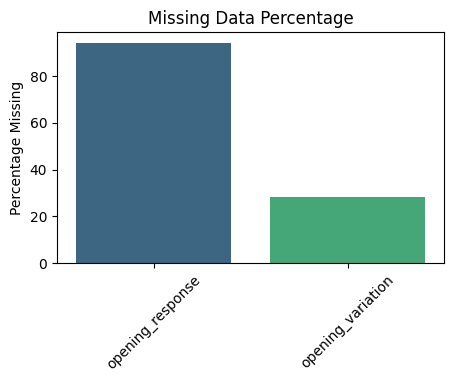

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

columns_to_analyze = ['opening_response', 'opening_variation']

# Створення пустого списку для зберігання відсоткового відношення пропусків
missing_percentages = []

# Отримання відсоткового відношення пропусків для кожної колонки
for column_name in columns_to_analyze:
    missing_percentage = (df[column_name].isnull().sum() / len(df)) * 100
    missing_percentages.append(missing_percentage)

# Створення стовпчикового графіка для відображення відсотків пропусків
plt.figure(figsize=(5, 3))
sns.barplot(x=columns_to_analyze, y=missing_percentages, palette='viridis')
plt.ylabel('Percentage Missing')
plt.title('Missing Data Percentage')
plt.xticks(rotation=45)
plt.show()

Є сенс видалити змінну 'opening response', а 'opening variation' заповнити модою.

In [12]:
# Видалення стовпця opening_response
df = df.drop(columns=['opening_response'])

# Заповнення стовпця opening_variation модою
mode_value = df['opening_variation'].mode()[0]
df['opening_variation'].fillna(mode_value, inplace=True)

In [13]:
df.nunique()

game_id              10029
turns                  197
victory_status           4
winner                   3
white_rating          1385
black_rating          1403
opening_moves           23
opening_shortname      126
opening_variation      519
time                    32
dtype: int64

Далі побудуємо боксплоти для того, щоб побачити як розділяються дані.

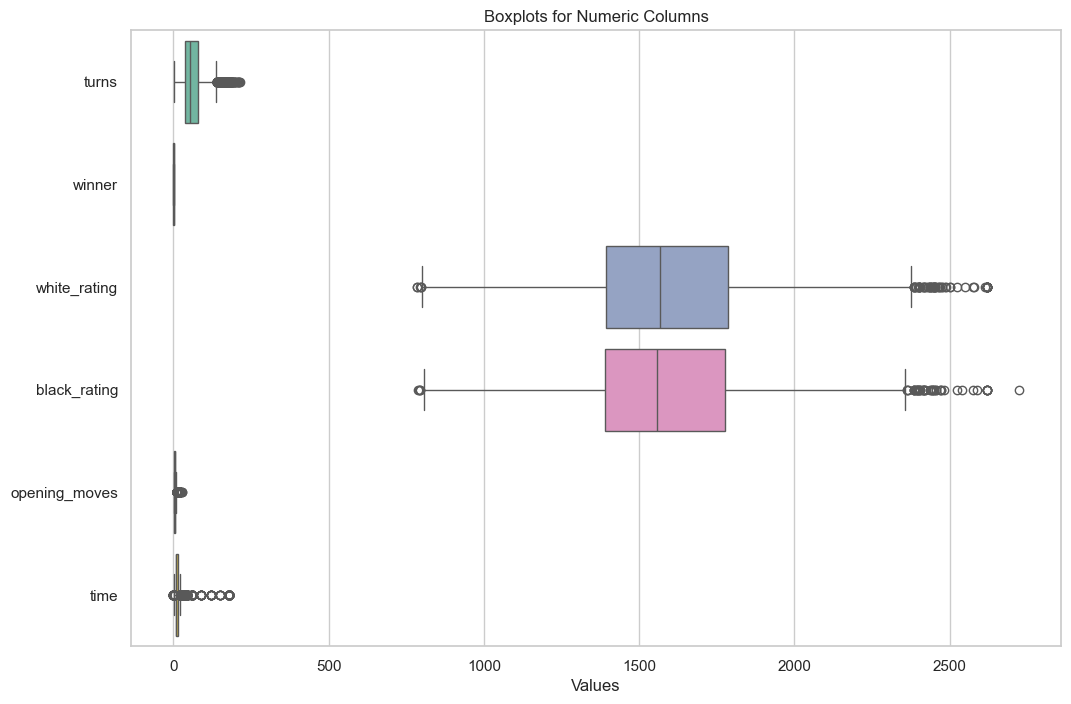

In [14]:
sns.set(style="whitegrid")
df = df.drop(columns=['game_id'])
# Побудуємо боксплоти для всіх числових стовпців
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, orient="h", palette="Set2")  # "h" означає горизонтальний боксплот
plt.title('Boxplots for Numeric Columns')
plt.xlabel('Values')
plt.show()

Більш ефективно буде подивитись на найбільш популярні опенінги в залежності від рейтингу гравців. Для прикладу можемо взяти тільки білих гравців, бо білі розпочинають гру та все одно завжди автоматично в противники підбирається чорний гравець з приблизно подібним рейтингом. 

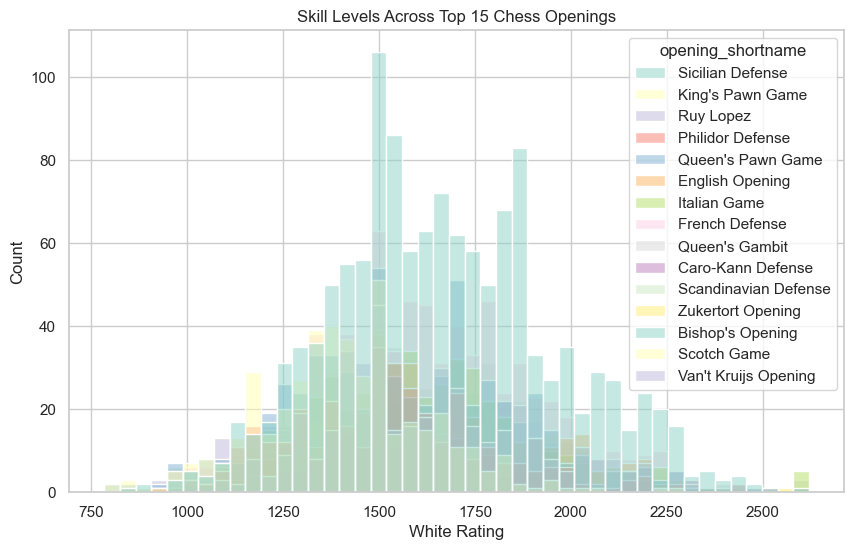

In [15]:
top_15_openings = df['opening_shortname'].value_counts()[:15].index

# To more cleanly display, I will sort top_15_openings by the mean white_rating
filtered_data = df.loc[df['opening_shortname'].isin(top_15_openings)]
order = filtered_data.groupby('opening_shortname')['white_rating'].mean().sort_values(ascending=False).index

# Plot skill level distributions across popular openings as a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_data, x='white_rating', hue='opening_shortname', 
             common_norm=False, palette='Set3')
plt.title('Skill Levels Across Top 15 Chess Openings')
plt.xlabel('White Rating')
plt.ylabel('Count')
plt.show()

З цього графіку можемо побачити, що найбільш популярним дебютом є Сицілійський захист. 

Далі проаналізуємо змінні які між собою найбільш корелюють і побудуємо боксплоти, щоб приблизно побачити кількість даних, які будуть заважати навчати модель.

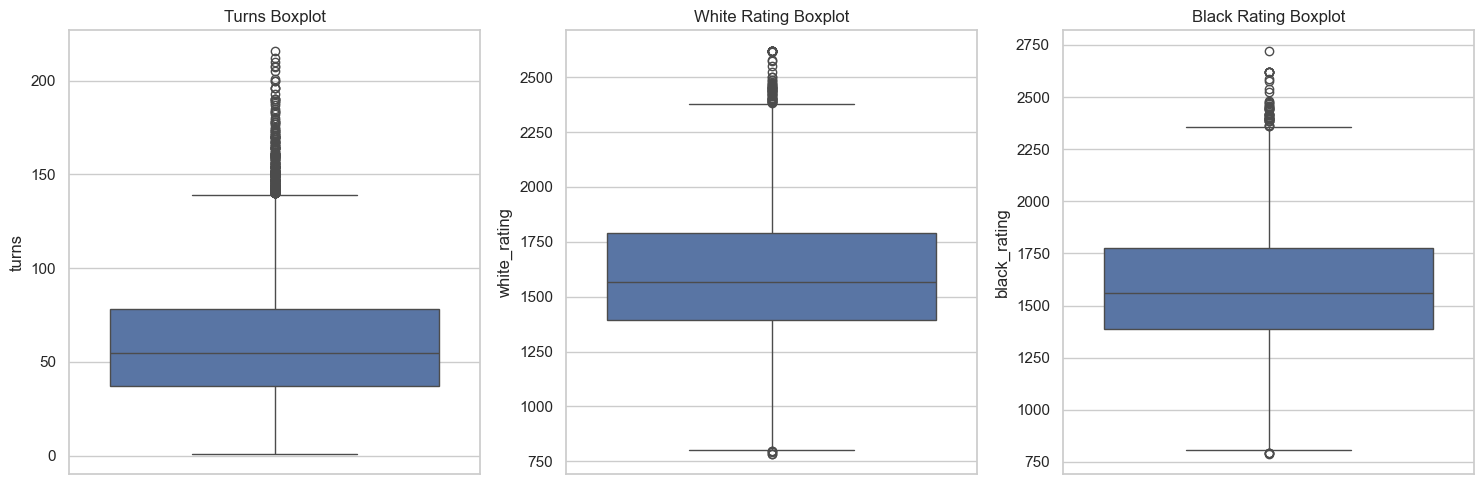

In [16]:
# Створення підграфіків
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Побудова боксплоту для 'turns'
sns.boxplot(data=df, y='turns', ax=axes[0])
axes[0].set_title('Turns Boxplot')

# Побудова боксплоту для 'white_rating'
sns.boxplot(data=df, y='white_rating', ax=axes[1])
axes[1].set_title('White Rating Boxplot')

# Побудова боксплоту для 'black_rating'
sns.boxplot(data=df, y='black_rating', ax=axes[2])
axes[2].set_title('Black Rating Boxplot')

# Відображення графіку
plt.tight_layout()
plt.show()

In [17]:
df.describe()

,turns,winner,white_rating,black_rating,opening_moves,time
count,10029.000000,10029.000000,10029.000000,10029.000000,10029.000000,10029.000000
mean,60.274803,0.589092,1594.914747,1586.272011,4.783029,13.781234
std,33.148273,0.578470,291.224008,289.618542,2.776617,17.323128
min,1.000000,0.000000,784.000000,789.000000,1.000000,0.000000
25%,37.000000,0.000000,1393.000000,1389.000000,3.000000,10.000000
50%,55.000000,1.000000,1567.000000,1559.000000,4.000000,10.000000
75%,78.000000,1.000000,1788.000000,1778.000000,6.000000,15.000000
max,216.000000,2.000000,2621.000000,2723.000000,28.000000,180.000000


Відкинемо зайві дані з кожної фітчі.

In [18]:
from scipy import stats

# Визначаємо викиди в «white_rating» і «black_rating» за допомогою Z-показника
threshold = 3
z_scores_white = np.abs(stats.zscore(df['white_rating']))
z_scores_black = np.abs(stats.zscore(df['black_rating']))
outliers_z_white = df[(z_scores_white > threshold)]
outliers_z_black = df[(z_scores_black > threshold)]


In [19]:
# Визначаємо викиди в «ходах» за допомогою IQR
Q1_turns = df['turns'].quantile(0.25)
Q3_turns = df['turns'].quantile(0.75)
IQR_turns = Q3_turns - Q1_turns
outliers_iqr_turns = df[(df['turns'] < Q1_turns - 1.5 * IQR_turns) | (df['turns'] > Q3_turns + 1.5 * IQR_turns)]

In [20]:
# Поєднуємо всі викидні умови
mask = ((z_scores_white <= threshold) &
        (z_scores_black <= threshold) &
        ~((df['turns'] < Q1_turns - 1.5 * IQR_turns) | (df['turns'] > Q3_turns + 1.5 * IQR_turns)))

# Створюємо чистий фрейм даних без викидів
df_clean = df[mask]

Тепер побудуємо графіки зі старого та нового датасету, щоб оцінити різницю.

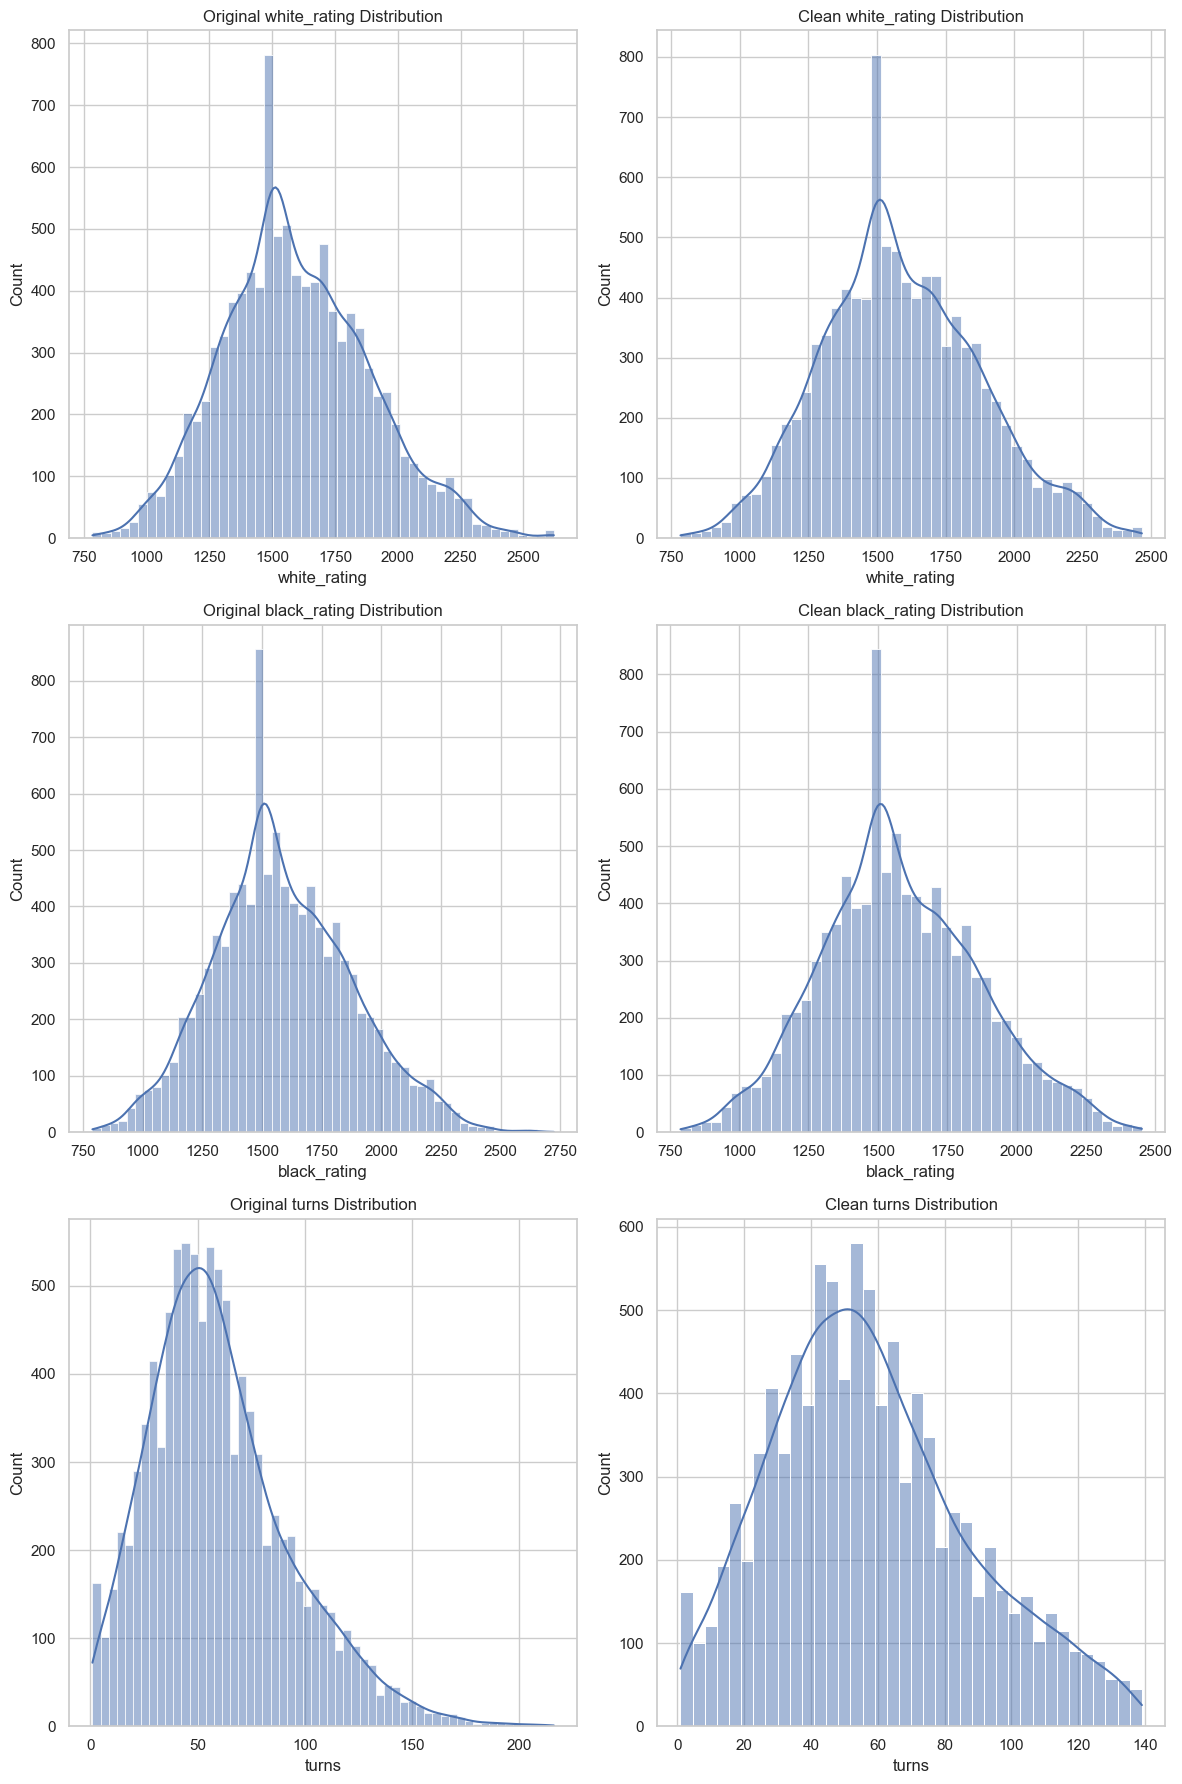

In [21]:
# Вимкнути попередження про is_categorical_dtype
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn._oldcore")

# Вимкнути попередження про use_inf_as_na
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

# Compare distributions before and after outlier removal
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

sns.histplot(df['white_rating'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Original white_rating Distribution')

sns.histplot(df_clean['white_rating'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Clean white_rating Distribution')

sns.histplot(df['black_rating'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Original black_rating Distribution')

sns.histplot(df_clean['black_rating'], ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Clean black_rating Distribution')

sns.histplot(df['turns'], ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Original turns Distribution')

sns.histplot(df_clean['turns'], ax=axes[2, 1], kde=True)
axes[2, 1].set_title('Clean turns Distribution')

plt.tight_layout()
plt.show()



Середня кількість ходів за гру трохи зменшилася після очищення, що вказує на те, що ігри з великою кількістю ходів були видалені.

На розподіли «white_rating» і «black_rating» лише незначно вплинуло видалення викидів, що свідчить про те, що в більшості ігор беруть участь гравці з рейтингами, близькими до середнього (1590-1600).

Більшість ігор передбачає 3-6 початкових ходів, що може вказувати на популярні стратегії в наборі даних.

Перетворимо дані з таргетованої змінної з даних у вигляді строки в числові, щоб побудувати ще графіки і для подальшої обробки даних. Також створимо колонки для різниці рейтингу та перевірки на більш великий рейтинг у білих.

In [22]:
# Створення копії DataFrame
df_clean['winner'] = df['winner'].replace({0: "Black", 1: "White", 2: "Draw"})

# Тепер можна внести зміни до df_clean без попереджень
df_clean['rating_diff'] = abs(df_clean['white_rating'] - df_clean['black_rating'])
df_clean['is_white_higher'] = (df_clean['white_rating'] > df_clean['black_rating']).astype(int)


# Encode 'winner' column 
df_clean = pd.get_dummies(df_clean, columns = ['winner'])
# Перейменування стовпців winner_0, winner_1, winner_2 в winner_Black, winner_White, winner_Draw
df_clean = df_clean.rename(columns={'winner_0': 'winner_Black', 'winner_1': 'winner_White', 'winner_2': 'winner_Draw'})


C:\Users\User\AppData\Local\Temp\ipykernel_6164\3226525897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['winner'] = df['winner'].replace({0: "Black", 1: "White", 2: "Draw"})
C:\Users\User\AppData\Local\Temp\ipykernel_6164\3226525897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['rating_diff'] = abs(df_clean['white_rating'] - df_clean['black_rating'])
C:\Users\User\AppData\Local\Temp\ipykernel_6164\3226525897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [23]:
df_clean.describe()

,turns,white_rating,black_rating,opening_moves,time,rating_diff,is_white_higher
count,9753.000000,9753.000000,9753.000000,9753.000000,9753.000000,9753.000000,9753.000000
mean,57.951195,1589.456783,1581.094125,4.762842,13.825387,171.998667,0.510920
std,29.743311,287.262959,286.647492,2.760550,17.446501,174.491433,0.499906
min,1.000000,784.000000,789.000000,1.000000,0.000000,0.000000,0.000000
25%,37.000000,1390.000000,1386.000000,3.000000,10.000000,46.000000,0.000000
50%,54.000000,1563.000000,1555.000000,4.000000,10.000000,115.000000,1.000000
75%,76.000000,1783.000000,1772.000000,6.000000,15.000000,242.000000,1.000000
max,139.000000,2465.000000,2451.000000,28.000000,180.000000,1492.000000,1.000000


In [24]:
df_clean.head()

,turns,victory_status,white_rating,black_rating,opening_moves,opening_shortname,opening_variation,time,rating_diff,is_white_higher,winner_Black,winner_Draw,winner_White
0,61,Resign,1919,1798,2,Dutch Defense,#2,10,121,1,False,False,True
1,86,Mate,1195,1123,4,Latvian Gambit,#2,10,72,1,True,False,False
2,27,Resign,1867,1932,9,Sicilian Defense,Accelerated Dragon,10,65,0,True,False,False
3,79,Resign,1823,1770,14,King's Indian Defense,Saemisch Variation,10,53,1,False,False,True
4,37,Resign,1371,1193,3,King's Pawn Game,Leonardis Variation,10,178,1,False,False,True


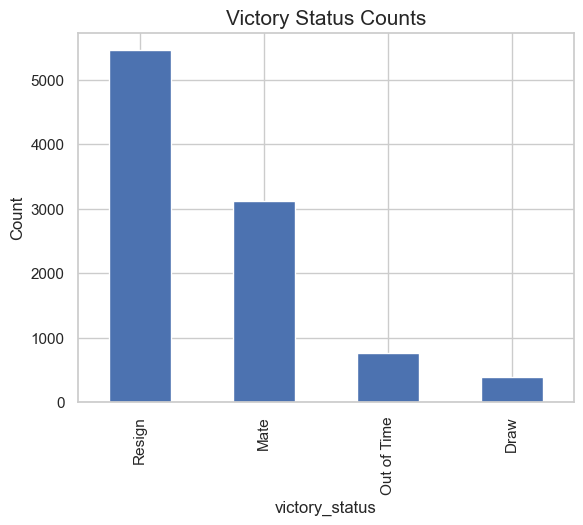

In [25]:
df_clean['victory_status'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Victory Status Counts', size = 15)
plt.show()

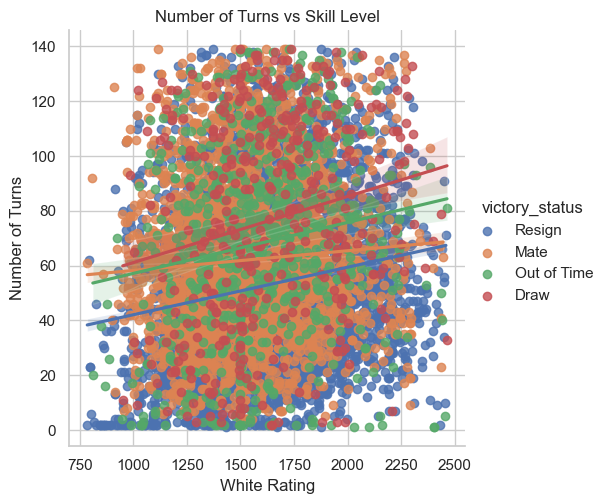

In [26]:
sns.lmplot(data = df_clean, 
           x = 'white_rating', 
           y = 'turns', 
           hue = 'victory_status')
plt.xlabel('White Rating')
plt.ylabel('Number of Turns')
plt.title('Number of Turns vs Skill Level')
plt.show()

Тут ми можемо спостерігати невеликий позитивний зв’язок між рівнем навичок і кількістю ходів. Ми також бачимо, що коли ми групуємо гру за матом, часом, нічиєю чи відставкою, нахил кожної лінії подібний. Основна відмінність полягає в тому, що ігри з відставкою зазвичай займають менше ходів, ніж гра внічию або гра, виграна вчасно. Ці результати очікувані, оскільки повторна реєстрація призведе до того, що партія буде скорочена за кілька ходів до того, як відбудеться мат або виграш вчасно.

### Висновки 

- Багато змінних дуже мало корелюють з таргетованою змінною, тобто ніяк не впливають на вірогідність виграшу гравця, тому таким чином можна було деякі просто відкинути.

- Найпопулярнішим опенінгом серед гравців є Сицілійський захист.

- Цілком гравці найбільше обирають режим гри по 10 хвилин.

- Більшість ігор закінчується тим, що хтось з гравців здається.

- Є певна залежність між кількістю ходів та результатом гри: ігри, де хтось здався, займають меншу кількість ходів.

- Зазвичай ігри відбуваються між ігроками приблизно однакового рейтингу.

- Більшість партій відбувається приблизно в межах 50-70 ходів.

## Класифікатори

Спочатку обираємо потрібні змінні для класифікації і розділяємо дані на тестові.

In [27]:
# Вибір потрібних змінних
y = df_clean['winner_Black']
x = df_clean[[ 'white_rating', 'black_rating', 'opening_moves', 'rating_diff', 'is_white_higher', 'victory_status']]
victory_status_map = {'Out of Time': 2, 'Resign': 0, 'Mate': 3, 'Draw': 1}
x['victory_status'] = x['victory_status'].map(victory_status_map)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


C:\Users\User\AppData\Local\Temp\ipykernel_6164\192916467.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['victory_status'] = x['victory_status'].map(victory_status_map)


### Decision tree

In [28]:
# Тренуємо модель дерева рішень
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

# Робимо прогноз на тестових даних
y_pred = tree.predict(x_test)

# Розраховуємо точність прогнозу
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: {:.2f}".format(accuracy))

# Виводимо результат
print(classification_report(y_test, y_pred))

Accuracy score: 0.62
              precision    recall  f1-score   support

       False       0.64      0.66      0.65      1058
        True       0.58      0.56      0.57       893

    accuracy                           0.62      1951
   macro avg       0.61      0.61      0.61      1951
weighted avg       0.61      0.62      0.61      1951



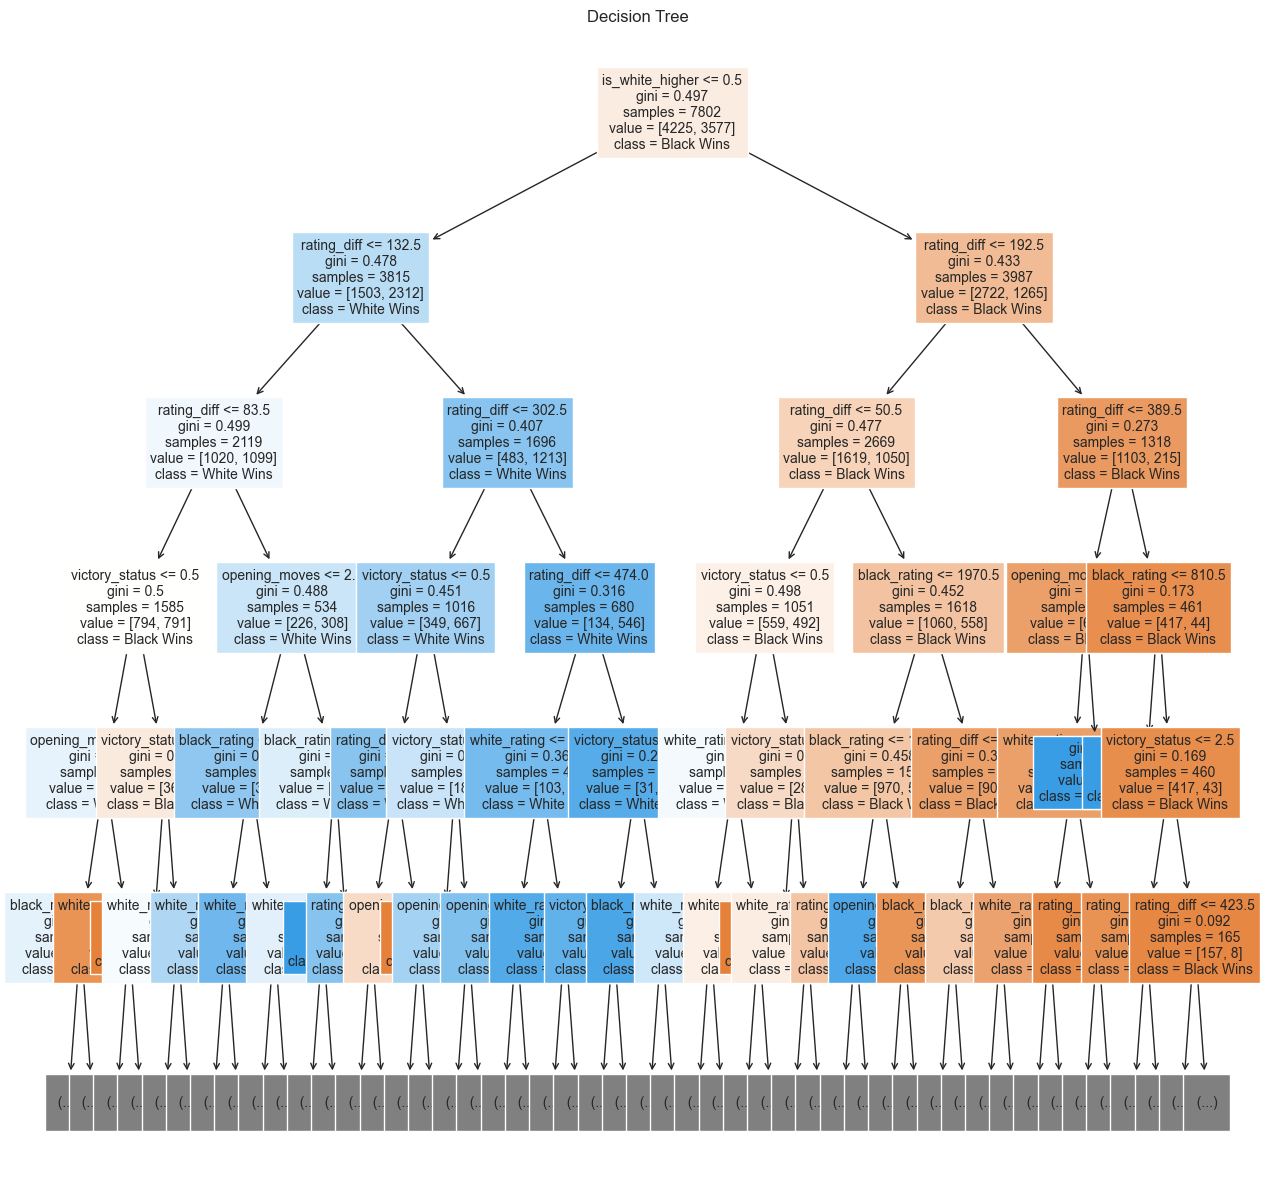

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train the Decision Tree model (якщо ще не навчили)

plt.figure(figsize=(15, 15))  # Встановлення розміру фігури (ширина, висота)
plot_tree(tree,
          feature_names=x_train.columns,
          class_names=["Black Wins", "White Wins"],  # Замініть це на відповідні класи в вашому датасеті
          filled=True,
          fontsize=10,  # Встановлюємо розмір шрифту для тексту на графіку
          max_depth=5)  # Встановлюємо максимальну глибину, яку ви хочете відобразити

plt.title("Decision Tree")
plt.show()



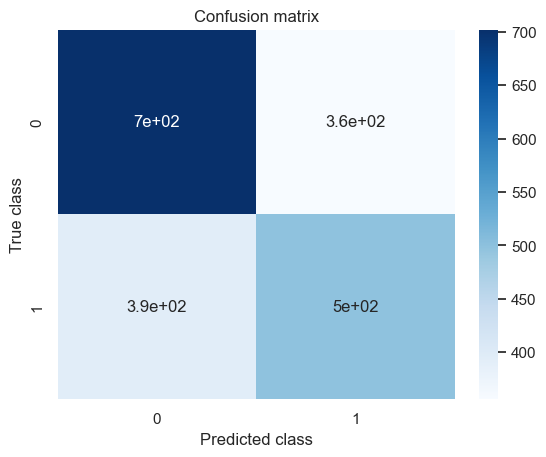

In [30]:
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, cmap="Blues")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')
plt.show()

### Adaboost

In [31]:
# AdaBoost
adb = AdaBoostClassifier()
adb.fit(x_train, y_train)
y_pred_adb = adb.predict(x_test)
accuracy_adb = accuracy_score(y_test, y_pred_adb)
print("Accuracy (AdaBoost):", accuracy_adb)

Accuracy (AdaBoost): 0.671963095848283


### Random forest

In [32]:
# Random Forest
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred_rfc = rfc.predict(x_test)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print("Accuracy (Random Forest):", accuracy_rfc)

Accuracy (Random Forest): 0.6581240389543823


### Random forest (GridSearch)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Створюємо модель Random Forest
rfc = RandomForestClassifier(random_state=42)

# Задаємо сітку параметрів, яку бажаємо перевірити
param_grid = {
    'n_estimators': [100, 200, 300],           # Кількість дерев у лісі
    'max_depth': [10, 30, 40],           # Максимальна глибина дерев
    'max_features': [None, 'sqrt', 'log2'],  # Правильні значення для max_features
}

# Створюємо об'єкт GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', error_score='raise')

# Проводимо пошук найкращих параметрів на тренувальних даних
grid_search.fit(x_train, y_train)

# Виводимо найкращі параметри та результат на тестових даних
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Використовуємо модель з найкращими параметрами
best_rfc = grid_search.best_estimator_
y_pred_rfc = best_rfc.predict(x_test)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print("Accuracy (Random Forest):", accuracy_rfc)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best Accuracy: 0.6600851689416711
Accuracy (Random Forest): 0.6704254228600718


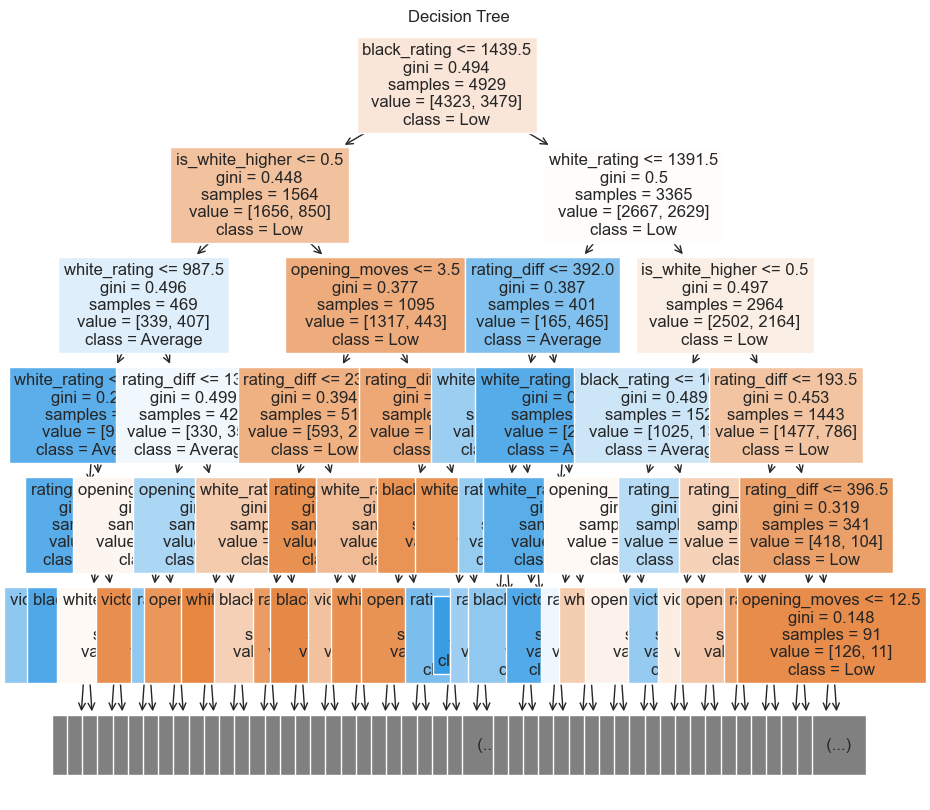

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Виберіть Decision Tree, яке ви хочете вивести (в даному випадку, перше дерево)
best_tree = best_rfc.estimators_[0]

plt.figure(figsize=(10, 10))  # Встановлення розміру фігури за допомогою кортежу (ширина, висота)
plot_tree(best_tree,
          feature_names=x_train.columns,
          class_names=["Low", "Average", "High"],
          filled=True,
          fontsize=12,  # Встановлюємо розмір шрифту для тексту на графіку
          max_depth=5)  # Встановлюємо максимальну глибину, яку ви хочете відобразити

plt.title("Decision Tree")
plt.show()

### KNN 

In [35]:
# K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy (K-Nearest Neighbors):", accuracy_knn)

Accuracy (K-Nearest Neighbors): 0.6319835981547924


### KNN(GridSearch)

In [36]:
# Створюємо модель KNN
knn = KNeighborsClassifier()

# Задаємо сітку параметрів, яку бажаємо перевірити
param_grid = {
    'n_neighbors': [5, 21, 83],        # Кількість сусідів
    'p': [1, 2, 3],                       # Використовувати Манхеттенську (p=1) або Евклідову (p=2) відстань
    'metric': ['minkowski'],
    'weights': ['uniform', 'distance'],
}

# Створюємо об'єкт GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

# Проводимо пошук найкращих параметрів на тренувальних даних
grid_search.fit(x_train, y_train)

# Виводимо найкращі параметри та результат на тестових даних
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Використовуємо модель з найкращими параметрами
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy (K-Nearest Neighbors):", accuracy_knn)


Best Parameters: {'metric': 'minkowski', 'n_neighbors': 83, 'p': 1, 'weights': 'distance'}
Best Accuracy: 0.6463703411685475
Accuracy (K-Nearest Neighbors): 0.6514607893388006


### SVM

In [37]:
# Support Vector Machine (SVM)
svm = SVC()
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy (Support Vector Machine):", accuracy_svm)

Accuracy (Support Vector Machine): 0.6401845207585853


### SVM(GridSearch)

In [38]:
import time 
tok = time.time()
# Задаємо сітку параметрів для перебору
param_grid = {
    'C': [0.1, 1, 10],           # Параметр регуляризації
    'kernel': [ 'rbf'],  # Тип ядра
    'gamma': [0.1, 1, 'scale'],   # Гамма для RBF ядра
}

# Створюємо об'єкт GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Запускаємо пошук
grid_search.fit(x_train, y_train)

# Отримуємо найкращі параметри
best_params = grid_search.best_params_

# Повторно навчаємо модель з найкращими параметрами
best_svm = SVC(**best_params)
best_svm.fit(x_train, y_train)

# Передбачення на тестовому наборі
y_pred_svm = best_svm.predict(x_test)

# Оцінка точності
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy (Support Vector Machine):", accuracy_svm)
tik = time.time()
print( tik - tok)


Accuracy (Support Vector Machine): 0.6427473090722706
63.49791646003723


In [39]:
print("Best Parameters:", best_svm)

Best Parameters: SVC(C=10)


## Висновки 
Найкрашим алгоритмом виявився метод випадкового лісу, який досягнув точності в 67% з підібраними парматерами за допомогою GridSearch. На жаль, більшу точність набрати не вийде через брак інших фітчей, які б більш корелювали з цільовою змінною.